In [271]:
import pandas as pd
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [32]:
# Load the datasets
new_person = pd.read_csv('synth_New_Person.csv')
new_family_hx = pd.read_csv('synth_New_FamilyHX.csv')
new_diagnosis = pd.read_csv('synth_New_Diagnosis.csv')
new_visits = pd.read_csv('synth_New_Visits.csv')

In [33]:
new_family_hx.shape

(59012, 5)

In [34]:
new_diagnosis.shape

(1227375, 10)

In [35]:
new_visits.shape

(205742, 14)

In [36]:
new_person.shape

(32913, 8)

In [37]:
unique_id_count = new_family_hx['PERSON_ID'].nunique()
print("Number of unique IDs:", unique_id_count)

Number of unique IDs: 15230


In [38]:
unique_id_count = new_diagnosis['PERSON_ID'].nunique()
print("Number of unique IDs:", unique_id_count)

Number of unique IDs: 32913


In [39]:
unique_id_count = new_person['PERSON_ID'].nunique()
print("Number of unique IDs:", unique_id_count)

Number of unique IDs: 32913


In [40]:
unique_id_count = new_visits['PERSON_ID'].nunique()
print("Number of unique IDs:", unique_id_count)

Number of unique IDs: 32913


### Family History Data Exploration

In [41]:
list(new_family_hx.columns.values)

['PERSON_ID', 'FHX_VALUE', 'CONDITION', 'RECORDED_DATE', 'HX_ID']

In [42]:
print(new_family_hx.head())

   PERSON_ID FHX_VALUE                      CONDITION  RECORDED_DATE  HX_ID
0      15207  POSITIVE                 Skin condition          -1366      0
1      10672  POSITIVE  Congestive heart failure.....            241      1
2      12751  POSITIVE         Endometrial cancer....            180      2
3       5305  NEGATIVE                       Cataract           -264      3
4      13458  POSITIVE             Cancer of prostate           -700      4


In [43]:
hypertension_cholesterol = ['High blood pressure', 'Hypertension', 'High cholesterol', 'Hypercholesteremia', 'Hyperlipidemia']
diabetes_conditions = ['Diabetes', 'Diabetes mellitus', 'Diabetes mellitus type 1']
cardiovascular_diseases = ['Heart Attack', 'Stroke', 'Heart Disease']

In [44]:
new_family_hx['Hypertension_Cholesterol'] = new_family_hx['CONDITION'].isin(hypertension_cholesterol).astype(int)
new_family_hx['Diabetes'] = new_family_hx['CONDITION'].isin(diabetes_conditions).astype(int)
new_family_hx['Cardiovascular_Diseases'] = new_family_hx['CONDITION'].isin(cardiovascular_diseases).astype(int)

family_hx_grouped = new_family_hx.groupby('PERSON_ID').agg({
    'Hypertension_Cholesterol': 'max',
    'Diabetes': 'max',
    'Cardiovascular_Diseases': 'max'
}).reset_index()

In [45]:
family_condition = new_family_hx.groupby('PERSON_ID')[['Hypertension_Cholesterol', 'Diabetes', 'Cardiovascular_Diseases']].max().reset_index()

In [46]:
print(family_condition.shape)

(15230, 4)


In [47]:
print(family_condition.head(100))

    PERSON_ID  Hypertension_Cholesterol  Diabetes  Cardiovascular_Diseases
0           0                         0         0                        0
1           1                         0         0                        0
2           2                         0         0                        1
3           3                         0         0                        0
4           4                         0         0                        0
..        ...                       ...       ...                      ...
95         95                         0         0                        0
96         96                         1         0                        0
97         97                         0         0                        0
98         98                         0         0                        0
99         99                         0         0                        0

[100 rows x 4 columns]


In [48]:
family_condition.Diabetes.describe()

count    15230.000000
mean         0.203349
std          0.402503
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Diabetes, dtype: float64

### Person (race/age) Data Exploration 

In [49]:
new_person.head()

,PERSON_ID,RACE,SEX,ETHNICITY,LANGUAGE,MARITAL_STATUS,AGE_GROUP,ZIP_TYPE
0,0,Other,Female,Non-Hispanic,English,Married,25-34,Urban
1,1,Other,Female,Non-Hispanic,Spanish,Single,25-34,Urban
2,2,White,Female,Hispanic,Spanish,Single,18-24,Urban
3,3,Unknown,Female,Non-Hispanic,English,Married,25-34,Urban
4,4,African American,Female,Non-Hispanic,English,Single,35-44,Urban


In [50]:
new_person.shape

(32913, 8)

In [51]:
person_race = new_person.groupby('PERSON_ID')[['RACE', 'AGE_GROUP', 'ETHNICITY', 'LANGUAGE', 'MARITAL_STATUS', 'ZIP_TYPE']].count().reset_index()
print(person_race.shape)

(32913, 7)


In [52]:
person_race.head(100)

,PERSON_ID,RACE,AGE_GROUP,ETHNICITY,LANGUAGE,MARITAL_STATUS,ZIP_TYPE
0,0,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,2,1,1,1,1,1,1
3,3,1,1,1,1,1,1
4,4,1,1,1,1,1,1
...,...,...,...,...,...,...,...
95,95,1,1,1,1,1,1
96,96,1,1,1,1,1,1
97,97,1,1,1,1,1,1
98,98,1,1,1,1,1,1


In [53]:
new_person['RACE'].unique()
frequency = new_person['RACE'].value_counts()
print(frequency)

White                                  14561
African American                        9153
Other                                   5052
Asian                                   1637
Unknown                                 1609
Multiple                                 413
Declined to Answer                       245
American Indian or Alaska Native         104
Hispanic/Spanish                          50
Native Hawaiian or Pacific Islander       48
Non Hispanic                              41
Name: RACE, dtype: int64


In [54]:
person_counts = new_person['RACE'].value_counts()
category_percentages = new_person['RACE'].value_counts(normalize=True) * 100
person_summary = pd.DataFrame({'Count': person_counts, 'Percentage': category_percentages})

print(person_summary)

                                     Count  Percentage
White                                14561   44.240877
African American                      9153   27.809680
Other                                 5052   15.349558
Asian                                 1637    4.973719
Unknown                               1609    4.888646
Multiple                               413    1.254823
Declined to Answer                     245    0.744387
American Indian or Alaska Native       104    0.315985
Hispanic/Spanish                        50    0.151916
Native Hawaiian or Pacific Islander     48    0.145839
Non Hispanic                            41    0.124571


In [55]:
new_person['AGE_GROUP'].unique()
frequency_age = new_person['AGE_GROUP'].value_counts()
print(frequency_age)

25-34    24989
35-44     5829
18-24     2095
Name: AGE_GROUP, dtype: int64


In [56]:
person_counts_age = new_person['AGE_GROUP'].value_counts()
category_percentages_age = new_person['AGE_GROUP'].value_counts(normalize=True) * 100

person_summary_age = pd.DataFrame({'Count': person_counts_age, 'Percentage': category_percentages_age})

print(person_summary_age)

       Count  Percentage
25-34  24989   75.924407
35-44   5829   17.710327
18-24   2095    6.365266


In [57]:
race_age = new_person[['PERSON_ID', 'RACE', 'AGE_GROUP', 'SEX', 'ETHNICITY', 'LANGUAGE', 'MARITAL_STATUS', 'ZIP_TYPE']]
print(race_age.shape)

(32913, 8)


### Visits Data Exploration

In [58]:
new_visits['FACILITY_TYPE'].unique()
frequency_facility = new_visits['FACILITY_TYPE'].value_counts()
print(frequency_facility)

Hospital                    74725
Women's Health              45173
OB/GYN                      34506
Maternal Fetal Medicine     18187
Perinatology                16712
Fetal Assessment            13407
Endocrinology                 327
Infusion Center               314
Family Planning               308
Primary Care                  236
Behavioral Health             215
Dermatology                   113
Cardiology                    108
COVID Screening               105
Internal Medicine             102
Infectious Disease            100
Pediatrics                     97
Family Medicine                80
Physical Medicine/Rehab        78
Urgent Care                    74
Neurology                      71
Rheumatology                   67
Pulmonology                    66
Endocrine                      66
Orthopaedics                   65
Oral Surgery                   64
Breast Health                  62
Surgical Ambulatory Care       60
Bariatric Surgery              46
General Surger

In [59]:
visits_counts_facility = new_visits['FACILITY_TYPE'].value_counts()
category_percentages_facility = new_visits['FACILITY_TYPE'].value_counts(normalize=True) * 100

# Combine both into a single DataFrame
visits_summary_facility = pd.DataFrame({'Count': visits_counts_facility, 'Percentage': category_percentages_facility})

print(visits_summary_facility)

                          Count  Percentage
Hospital                  74725   36.319760
Women's Health            45173   21.956139
OB/GYN                    34506   16.771491
Maternal Fetal Medicine   18187    8.839712
Perinatology              16712    8.122795
Fetal Assessment          13407    6.516414
Endocrinology               327    0.158937
Infusion Center             314    0.152618
Family Planning             308    0.149702
Primary Care                236    0.114707
Behavioral Health           215    0.104500
Dermatology                 113    0.054923
Cardiology                  108    0.052493
COVID Screening             105    0.051035
Internal Medicine           102    0.049577
Infectious Disease          100    0.048605
Pediatrics                   97    0.047146
Family Medicine              80    0.038884
Physical Medicine/Rehab      78    0.037912
Urgent Care                  74    0.035967
Neurology                    71    0.034509
Rheumatology                 67 

In [60]:
new_visits['REASON_FOR_VISIT'].unique()
frequency_reason = new_visits['REASON_FOR_VISIT'].value_counts()
print(frequency_reason)

ROB                               9370
C-SECTION DELIVERY                2416
rob 1hr gulcose                   2349
RTN OB                            1840
35WKS CONTRACTIONS                1803
                                  ... 
IUP/40WKS/CTX OB SHORTSTAY           1
(159) SGA, LAGGING AC, FMHX CH       1
TERM PREGNANCY FOR LABOR             1
NST/SINGLE FETUS/36WKS               1
(193) S> D, 5/27/18                  1
Name: REASON_FOR_VISIT, Length: 23171, dtype: int64


In [61]:
visits_counts_reason = new_visits['REASON_FOR_VISIT'].value_counts()
category_percentages_reason = new_visits['REASON_FOR_VISIT'].value_counts(normalize=True) * 100

visits_summary_reason = pd.DataFrame({'Count': visits_counts_reason, 'Percentage': category_percentages_reason})

print(visits_summary_reason)

                                Count  Percentage
ROB                              9370    4.554248
C-SECTION DELIVERY               2416    1.174286
rob 1hr gulcose                  2349    1.141721
RTN OB                           1840    0.894324
35WKS CONTRACTIONS               1803    0.876340
...                               ...         ...
IUP/40WKS/CTX OB SHORTSTAY          1    0.000486
(159) SGA, LAGGING AC, FMHX CH      1    0.000486
TERM PREGNANCY FOR LABOR            1    0.000486
NST/SINGLE FETUS/36WKS              1    0.000486
(193) S> D, 5/27/18                 1    0.000486

[23171 rows x 2 columns]


In [62]:
new_visits['PRIMARY_INSURANCE_GRP'].unique()
frequency_insurance = new_visits['PRIMARY_INSURANCE_GRP'].value_counts()
print(frequency_insurance)

HMO                       90524
MEDICAID HMO              56679
BLUE CROSS                22916
Commercial                11210
Unknown                    9139
Medicaid                   8145
SPECIALITY BILLLING        4592
Self Pay                   1052
Medicare                    892
MEDICAREHMO                 243
Medcaid-Pending Agency      134
INSTITUTIONAL BILLING        80
Medcaid-Pending INHSE        77
WORKERS COMPENSATION         59
Name: PRIMARY_INSURANCE_GRP, dtype: int64


In [63]:
visits_counts_insurance = new_visits['PRIMARY_INSURANCE_GRP'].value_counts()
category_percentages_insurance = new_visits['PRIMARY_INSURANCE_GRP'].value_counts(normalize=True) * 100

# Combine both into a single DataFrame
visits_summary_insurance = pd.DataFrame({'Count': visits_counts_insurance, 'Percentage': category_percentages_insurance})

print(visits_summary_insurance)

                        Count  Percentage
HMO                     90524   43.998795
MEDICAID HMO            56679   27.548580
BLUE CROSS              22916   11.138222
Commercial              11210    5.448572
Unknown                  9139    4.441971
Medicaid                 8145    3.958842
SPECIALITY BILLLING      4592    2.231922
Self Pay                 1052    0.511320
Medicare                  892    0.433553
MEDICAREHMO               243    0.118109
Medcaid-Pending Agency    134    0.065130
INSTITUTIONAL BILLING      80    0.038884
Medcaid-Pending INHSE      77    0.037426
WORKERS COMPENSATION       59    0.028677


In [64]:
visits_table = new_visits[['PERSON_ID','VISIT_TYPE', 'AGE_AT_ENCNTR_GROUP','DISCH_DAYS_FROM_INDEX', 'FACILITY_TYPE', 'ADMIT_TYPE', 'ENCNTR_TYPE', 'REASON_FOR_VISIT', 'PRIMARY_INSURANCE_GRP']]
print(visits_table.shape)

(205742, 9)


In [65]:
visits_table2 = new_visits[['PERSON_ID','VISIT_TYPE','DISCH_DAYS_FROM_INDEX', 'FACILITY_TYPE', 'ADMIT_TYPE', 'ENCNTR_TYPE', 'PRIMARY_INSURANCE_GRP']]
print(visits_table2.shape)

(205742, 7)


In [66]:
new_visit_table = new_visits[['PERSON_ID', 'REASON_FOR_VISIT']]
print(new_visit_table.shape)

(205742, 2)


In [67]:
visits_table2.head()

,PERSON_ID,VISIT_TYPE,DISCH_DAYS_FROM_INDEX,FACILITY_TYPE,ADMIT_TYPE,ENCNTR_TYPE,PRIMARY_INSURANCE_GRP
0,24299,P,1306,Perinatology,Elective,Clinic,HMO
1,27338,P,161,OB/GYN,Elective,Clinic,Self Pay
2,8729,P,138,Maternal Fetal Medicine,Elective,Clinic,Commercial
3,6546,P,60,Perinatology,Routine Elective Admission,Clinic,Medicaid
4,19653,P,138,Women's Health,Elective,Clinic,MEDICAID HMO


In [68]:
category_counts = new_visit_table['REASON_FOR_VISIT'].value_counts()

top_50_categories = category_counts.head(50).index

new_visit_table['Category_Top50'] = new_visit_table['REASON_FOR_VISIT'].apply(lambda x: x if x in top_50_categories else 'Other')

df_dummies = pd.get_dummies(new_visit_table, columns=['Category_Top50'])

df_final = df_dummies[['PERSON_ID'] + [col for col in df_dummies.columns if col != 'PERSON_ID']]

print(df_final.head())

   PERSON_ID                          REASON_FOR_VISIT  \
0      24299  Has not Felt the baby since 2pm yesterda   
1      27338                 38 WKS 5 DYS CONTRACTIONS   
2       8729                   NEW(215) GDM A2, 1/1/20   
3       6546                                  DEAFNESS   
4      19653                                 28WKS MVA   

   Category_Top50_(258)SEIZURE DIS,ON MEDS,EDC 8  Category_Top50_11 WKS FTU  \
0                                              0                          0   
1                                              0                          0   
2                                              0                          0   
3                                              0                          0   
4                                              0                          0   

   Category_Top50_28WKS MVA  Category_Top50_31WKS STOMACH BACK PAIN  \
0                         0                                       0   
1                         0       

/var/folders/c7/mwgyyxds33bg8rksxm07_r_00000gn/T/ipykernel_15097/1054856352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_visit_table['Category_Top50'] = new_visit_table['REASON_FOR_VISIT'].apply(lambda x: x if x in top_50_categories else 'Other')


In [69]:
df_dropped = df_final.drop(columns=['REASON_FOR_VISIT'])

df_final.drop(columns=['REASON_FOR_VISIT'], inplace=True)

print(df_dropped)

        PERSON_ID  Category_Top50_(258)SEIZURE DIS,ON MEDS,EDC 8  \
0           24299                                              0   
1           27338                                              0   
2            8729                                              0   
3            6546                                              0   
4           19653                                              0   
...           ...                                            ...   
205737      22563                                              0   
205738      23118                                              0   
205739      28733                                              0   
205740      31985                                              0   
205741      19307                                              0   

        Category_Top50_11 WKS FTU  Category_Top50_28WKS MVA  \
0                               0                         0   
1                               0                        

In [70]:
df_unique = df_final.drop_duplicates()

print(df_unique)

        PERSON_ID  Category_Top50_(258)SEIZURE DIS,ON MEDS,EDC 8  \
0           24299                                              0   
1           27338                                              0   
2            8729                                              0   
3            6546                                              0   
4           19653                                              0   
...           ...                                            ...   
205729         19                                              0   
205730      30011                                              0   
205734      30663                                              0   
205735      17715                                              0   
205737      22563                                              0   

        Category_Top50_11 WKS FTU  Category_Top50_28WKS MVA  \
0                               0                         0   
1                               0                        

In [71]:
list(df_final.columns.values)

['PERSON_ID',
 'Category_Top50_(258)SEIZURE DIS,ON MEDS,EDC 8',
 'Category_Top50_11 WKS FTU',
 'Category_Top50_28WKS MVA',
 'Category_Top50_31WKS STOMACH BACK PAIN',
 'Category_Top50_33WKS HBP',
 'Category_Top50_33WKS//CONTRACTIONS/ HEADACHES//',
 'Category_Top50_35WKS CONTRACTIONS',
 'Category_Top50_36WKS LWR BACK PAIN',
 'Category_Top50_37 WKS WATER BROKE/LEW',
 'Category_Top50_38 WKS 5 DYS CONTRACTIONS',
 'Category_Top50_39 WEEKS-INDUCTION',
 'Category_Top50_40 WEEKS PREGNANT',
 'Category_Top50_40 WKS PREGNANT',
 'Category_Top50_6 WK RET OB',
 'Category_Top50_BPP / PER DR.KATZ',
 'Category_Top50_BREECH, 33WKS',
 'Category_Top50_C&C,20 WEEKS ABD PAIN',
 'Category_Top50_C&C,41 WEEKS CONTRACTIONS',
 'Category_Top50_C-SECTION DELIVERY',
 'Category_Top50_COLPO, RETURN OB AFTER',
 'Category_Top50_FTU/76801',
 'Category_Top50_IGU',
 'Category_Top50_IGU/BPP',
 'Category_Top50_IUP 39.4 WKS HIGH BP FEMALE/VAGINAL',
 'Category_Top50_IUP/35.2 WKS/LMP 10312019 LEAKING FLUID/SHST',
 'Category_Top

In [139]:
reason_for_visit = df_final.groupby('PERSON_ID')[[
 'Category_Top50_(258)SEIZURE DIS,ON MEDS,EDC 8',
 'Category_Top50_11 WKS FTU',
 'Category_Top50_28WKS MVA',
 'Category_Top50_31WKS STOMACH BACK PAIN',
 'Category_Top50_33WKS HBP',
 'Category_Top50_33WKS//CONTRACTIONS/ HEADACHES//',
 'Category_Top50_35WKS CONTRACTIONS',
 'Category_Top50_36WKS LWR BACK PAIN',
 'Category_Top50_37 WKS WATER BROKE/LEW',
 'Category_Top50_38 WKS 5 DYS CONTRACTIONS',
 'Category_Top50_39 WEEKS-INDUCTION',
 'Category_Top50_40 WEEKS PREGNANT',
 'Category_Top50_40 WKS PREGNANT',
 'Category_Top50_6 WK RET OB',
 'Category_Top50_BPP / PER DR.KATZ',
 'Category_Top50_BREECH, 33WKS',
 'Category_Top50_C&C,20 WEEKS ABD PAIN',
 'Category_Top50_C&C,41 WEEKS CONTRACTIONS',
 'Category_Top50_C-SECTION DELIVERY',
 'Category_Top50_COLPO, RETURN OB AFTER',
 'Category_Top50_FTU/76801',
 'Category_Top50_IGU',
 'Category_Top50_IGU/BPP',
 'Category_Top50_IUP 39.4 WKS HIGH BP FEMALE/VAGINAL',
 'Category_Top50_IUP/35.2 WKS/LMP 10312019 LEAKING FLUID/SHST',
 'Category_Top50_IUP/36.1 WKS/CONTRAX/OBSH ST/LMP 011420',
 'Category_Top50_IUP/38.4WKS/CONTRACTION/ FEMALE/C SECTION',
 'Category_Top50_N92.6 Z34A.01',
 'Category_Top50_NEW OB LMP 3/11??',
 'Category_Top50_NEW OB NO PNC LMP UNKNOWN',
 'Category_Top50_NOB',
 'Category_Top50_NST',
 'Category_Top50_NST/INJ ; EST PT',
 'Category_Top50_NST; EST PT',
 'Category_Top50_O99.212 G43.909 Z3A.10 US OB',
 'Category_Top50_O99.283,Z3A.33,Z67.91',
 'Category_Top50_OB',
 'Category_Top50_OB 240-585-2500 ROB',
 'Category_Top50_Ob Appt',
 'Category_Top50_Other',
 'Category_Top50_PREGNANCY 37 WKS',
 'Category_Top50_PREGNANCY PRIVATE  38.6 INDUCTION',
 'Category_Top50_RETURN OB',
 'Category_Top50_ROB',
 'Category_Top50_ROB 35 WEEKS',
 'Category_Top50_RTN OB',
 'Category_Top50_VAG DELIVERY 36.4 WEEKS',
 'Category_Top50_VAGINAL DELIVERY 40.3 WKS MATERNITY SVC',
 'Category_Top50_ob + COVID exposure awaiting results',
 'Category_Top50_rob',
 'Category_Top50_rob 1hr gulcose']].max().reset_index()
reason_for_visit.shape

(32913, 52)

In [140]:
visits_table2.head()

,PERSON_ID,VISIT_TYPE,DISCH_DAYS_FROM_INDEX,FACILITY_TYPE,ADMIT_TYPE,ENCNTR_TYPE,PRIMARY_INSURANCE_GRP
0,24299,P,1306,Perinatology,Elective,Clinic,HMO
1,27338,P,161,OB/GYN,Elective,Clinic,Self Pay
2,8729,P,138,Maternal Fetal Medicine,Elective,Clinic,Commercial
3,6546,P,60,Perinatology,Routine Elective Admission,Clinic,Medicaid
4,19653,P,138,Women's Health,Elective,Clinic,MEDICAID HMO


## Facility Type 

In [141]:
new_facility_table = new_visits[['PERSON_ID', 'FACILITY_TYPE']]
print(new_facility_table.shape)  # Check the shape of the DataFrame

facility_dummies = pd.get_dummies(new_facility_table, columns=['FACILITY_TYPE'])

facility_final = facility_dummies[['PERSON_ID'] + [col for col in facility_dummies.columns if col != 'PERSON_ID']]
print(facility_final)

print(facility_final)

(205742, 2)
        PERSON_ID  FACILITY_TYPE_Bariatric Surgery  \
0           24299                                0   
1           27338                                0   
2            8729                                0   
3            6546                                0   
4           19653                                0   
...           ...                              ...   
205737      22563                                0   
205738      23118                                0   
205739      28733                                0   
205740      31985                                0   
205741      19307                                0   

        FACILITY_TYPE_Behavioral Health  FACILITY_TYPE_Breast Health  \
0                                     0                            0   
1                                     0                            0   
2                                     0                            0   
3                                     0            

In [142]:
facility_unique = facility_final.drop_duplicates()

print(facility_unique)

        PERSON_ID  FACILITY_TYPE_Bariatric Surgery  \
0           24299                                0   
1           27338                                0   
2            8729                                0   
3            6546                                0   
4           19653                                0   
...           ...                              ...   
205710       1121                                0   
205718       8187                                0   
205729         19                                0   
205732      30648                                0   
205738      23118                                0   

        FACILITY_TYPE_Behavioral Health  FACILITY_TYPE_Breast Health  \
0                                     0                            0   
1                                     0                            0   
2                                     0                            0   
3                                     0                        

In [143]:
list(facility_final.columns.values)

['PERSON_ID',
 'FACILITY_TYPE_Bariatric Surgery',
 'FACILITY_TYPE_Behavioral Health',
 'FACILITY_TYPE_Breast Health',
 'FACILITY_TYPE_COVID Screening',
 'FACILITY_TYPE_Cardiology',
 'FACILITY_TYPE_Dermatology',
 'FACILITY_TYPE_Endocrine',
 'FACILITY_TYPE_Endocrinology',
 'FACILITY_TYPE_Family Medicine',
 'FACILITY_TYPE_Family Planning',
 'FACILITY_TYPE_Fetal Assessment',
 'FACILITY_TYPE_Gastroenterology',
 'FACILITY_TYPE_General Surgery',
 'FACILITY_TYPE_Hematology/Oncology',
 'FACILITY_TYPE_Hospital',
 'FACILITY_TYPE_Infectious Disease',
 'FACILITY_TYPE_Infusion Center',
 'FACILITY_TYPE_Internal Medicine',
 'FACILITY_TYPE_Maternal Fetal Medicine',
 'FACILITY_TYPE_Nephrology',
 'FACILITY_TYPE_Neurology',
 'FACILITY_TYPE_Neuropsychiatry',
 'FACILITY_TYPE_OB/GYN',
 'FACILITY_TYPE_Oral Surgery',
 'FACILITY_TYPE_Orthopaedics',
 'FACILITY_TYPE_Pediatrics',
 'FACILITY_TYPE_Perinatology',
 'FACILITY_TYPE_Physical Medicine/Rehab',
 'FACILITY_TYPE_Primary Care',
 'FACILITY_TYPE_Pulmonology',
 '

In [144]:
facility_type = facility_final.groupby('PERSON_ID')[['FACILITY_TYPE_Bariatric Surgery',
 'FACILITY_TYPE_Behavioral Health',
 'FACILITY_TYPE_Breast Health',
 'FACILITY_TYPE_COVID Screening',
 'FACILITY_TYPE_Cardiology',
 'FACILITY_TYPE_Dermatology',
 'FACILITY_TYPE_Endocrine',
 'FACILITY_TYPE_Endocrinology',
 'FACILITY_TYPE_Family Medicine',
 'FACILITY_TYPE_Family Planning',
 'FACILITY_TYPE_Fetal Assessment',
 'FACILITY_TYPE_Gastroenterology',
 'FACILITY_TYPE_General Surgery',
 'FACILITY_TYPE_Hematology/Oncology',
 'FACILITY_TYPE_Hospital',
 'FACILITY_TYPE_Infectious Disease',
 'FACILITY_TYPE_Infusion Center',
 'FACILITY_TYPE_Internal Medicine',
 'FACILITY_TYPE_Maternal Fetal Medicine',
 'FACILITY_TYPE_Nephrology',
 'FACILITY_TYPE_Neurology',
 'FACILITY_TYPE_Neuropsychiatry',
 'FACILITY_TYPE_OB/GYN',
 'FACILITY_TYPE_Oral Surgery',
 'FACILITY_TYPE_Orthopaedics',
 'FACILITY_TYPE_Pediatrics',
 'FACILITY_TYPE_Perinatology',
 'FACILITY_TYPE_Physical Medicine/Rehab',
 'FACILITY_TYPE_Primary Care',
 'FACILITY_TYPE_Pulmonology',
 'FACILITY_TYPE_Rheumatology',
 'FACILITY_TYPE_Surgical Ambulatory Care',
 'FACILITY_TYPE_Urgent Care',
 'FACILITY_TYPE_Urology',
 "FACILITY_TYPE_Women's Health"]].max().reset_index()
facility_type.shape

(32913, 36)

## Insurance Type

In [145]:
new_insurance_table = new_visits[['PERSON_ID', 'PRIMARY_INSURANCE_GRP']]
print(new_insurance_table.shape)  # Check the shape of the DataFrame

insurance_dummies = pd.get_dummies(new_insurance_table, columns=['PRIMARY_INSURANCE_GRP'])

insurance_final = insurance_dummies[['PERSON_ID'] + [col for col in insurance_dummies.columns if col != 'PERSON_ID']]
print(insurance_final)

print(insurance_final)

(205742, 2)
        PERSON_ID  PRIMARY_INSURANCE_GRP_BLUE CROSS  \
0           24299                                 0   
1           27338                                 0   
2            8729                                 0   
3            6546                                 0   
4           19653                                 0   
...           ...                               ...   
205737      22563                                 0   
205738      23118                                 0   
205739      28733                                 0   
205740      31985                                 0   
205741      19307                                 0   

        PRIMARY_INSURANCE_GRP_Commercial  PRIMARY_INSURANCE_GRP_HMO  \
0                                      0                          1   
1                                      0                          0   
2                                      1                          0   
3                                      0   

In [146]:
insurance_unique = insurance_final.drop_duplicates()

print(insurance_unique)

        PERSON_ID  PRIMARY_INSURANCE_GRP_BLUE CROSS  \
0           24299                                 0   
1           27338                                 0   
2            8729                                 0   
3            6546                                 0   
4           19653                                 0   
...           ...                               ...   
205729         19                                 0   
205730      30011                                 0   
205735      17715                                 0   
205739      28733                                 0   
205741      19307                                 0   

        PRIMARY_INSURANCE_GRP_Commercial  PRIMARY_INSURANCE_GRP_HMO  \
0                                      0                          1   
1                                      0                          0   
2                                      1                          0   
3                                      0               

In [147]:
list(insurance_final.columns.values)

['PERSON_ID',
 'PRIMARY_INSURANCE_GRP_BLUE CROSS',
 'PRIMARY_INSURANCE_GRP_Commercial',
 'PRIMARY_INSURANCE_GRP_HMO',
 'PRIMARY_INSURANCE_GRP_INSTITUTIONAL BILLING',
 'PRIMARY_INSURANCE_GRP_MEDICAID HMO',
 'PRIMARY_INSURANCE_GRP_MEDICAREHMO',
 'PRIMARY_INSURANCE_GRP_Medcaid-Pending Agency',
 'PRIMARY_INSURANCE_GRP_Medcaid-Pending INHSE',
 'PRIMARY_INSURANCE_GRP_Medicaid',
 'PRIMARY_INSURANCE_GRP_Medicare',
 'PRIMARY_INSURANCE_GRP_SPECIALITY BILLLING',
 'PRIMARY_INSURANCE_GRP_Self Pay',
 'PRIMARY_INSURANCE_GRP_Unknown',
 'PRIMARY_INSURANCE_GRP_WORKERS COMPENSATION']

In [148]:
insurance_type = insurance_final.groupby('PERSON_ID')[['PRIMARY_INSURANCE_GRP_BLUE CROSS',
 'PRIMARY_INSURANCE_GRP_Commercial',
 'PRIMARY_INSURANCE_GRP_HMO',
 'PRIMARY_INSURANCE_GRP_INSTITUTIONAL BILLING',
 'PRIMARY_INSURANCE_GRP_MEDICAID HMO',
 'PRIMARY_INSURANCE_GRP_MEDICAREHMO',
 'PRIMARY_INSURANCE_GRP_Medcaid-Pending Agency',
 'PRIMARY_INSURANCE_GRP_Medcaid-Pending INHSE',
 'PRIMARY_INSURANCE_GRP_Medicaid',
 'PRIMARY_INSURANCE_GRP_Medicare',
 'PRIMARY_INSURANCE_GRP_SPECIALITY BILLLING',
 'PRIMARY_INSURANCE_GRP_Self Pay',
 'PRIMARY_INSURANCE_GRP_Unknown',
 'PRIMARY_INSURANCE_GRP_WORKERS COMPENSATION']].max().reset_index()
insurance_type.shape

(32913, 15)

## Admit Type

In [149]:
new_admit_table = new_visits[['PERSON_ID', 'ADMIT_TYPE']]
print(new_admit_table.shape)  # Check the shape of the DataFrame

admit_dummies = pd.get_dummies(new_admit_table, columns=['ADMIT_TYPE'])

admit_final = admit_dummies[['PERSON_ID'] + [col for col in admit_dummies.columns if col != 'PERSON_ID']]
print(admit_final)

print(admit_final)

(205742, 2)
        PERSON_ID  ADMIT_TYPE_Elective  ADMIT_TYPE_Emergency  \
0           24299                    1                     0   
1           27338                    1                     0   
2            8729                    1                     0   
3            6546                    0                     0   
4           19653                    1                     0   
...           ...                  ...                   ...   
205737      22563                    1                     0   
205738      23118                    0                     0   
205739      28733                    0                     0   
205740      31985                    1                     0   
205741      19307                    0                     0   

        ADMIT_TYPE_Information Not Available  ADMIT_TYPE_Newborn  \
0                                          0                   0   
1                                          0                   0   
2              

In [150]:
admit_unique = admit_final.drop_duplicates()

print(admit_unique)

        PERSON_ID  ADMIT_TYPE_Elective  ADMIT_TYPE_Emergency  \
0           24299                    1                     0   
1           27338                    1                     0   
2            8729                    1                     0   
3            6546                    0                     0   
4           19653                    1                     0   
...           ...                  ...                   ...   
205710       1121                    0                     1   
205713      27188                    0                     0   
205718       8187                    1                     0   
205729         19                    1                     0   
205731      28754                    0                     1   

        ADMIT_TYPE_Information Not Available  ADMIT_TYPE_Newborn  \
0                                          0                   0   
1                                          0                   0   
2                          

In [151]:
list(admit_final.columns.values)

['PERSON_ID',
 'ADMIT_TYPE_Elective',
 'ADMIT_TYPE_Emergency',
 'ADMIT_TYPE_Information Not Available',
 'ADMIT_TYPE_Newborn',
 'ADMIT_TYPE_Other',
 'ADMIT_TYPE_Pregnancy/Delivery',
 'ADMIT_TYPE_Psychiatric',
 'ADMIT_TYPE_Rehabilitation',
 'ADMIT_TYPE_Routine Elective Admission',
 'ADMIT_TYPE_Sem-Urgent',
 'ADMIT_TYPE_Term Pregnancy',
 'ADMIT_TYPE_Unknown',
 'ADMIT_TYPE_Urgent']

In [152]:
admit_type = admit_final.groupby('PERSON_ID')[['ADMIT_TYPE_Elective',
 'ADMIT_TYPE_Emergency',
 'ADMIT_TYPE_Information Not Available',
 'ADMIT_TYPE_Newborn',
 'ADMIT_TYPE_Other',
 'ADMIT_TYPE_Pregnancy/Delivery',
 'ADMIT_TYPE_Psychiatric',
 'ADMIT_TYPE_Rehabilitation',
 'ADMIT_TYPE_Routine Elective Admission',
 'ADMIT_TYPE_Sem-Urgent',
 'ADMIT_TYPE_Term Pregnancy',
 'ADMIT_TYPE_Unknown',
 'ADMIT_TYPE_Urgent']].max().reset_index()
admit_type.shape

(32913, 14)

## Encntr Type

In [153]:
new_encntr_table = new_visits[['PERSON_ID', 'ENCNTR_TYPE']]
print(new_encntr_table.shape)  # Check the shape of the DataFrame

encntr_dummies = pd.get_dummies(new_encntr_table, columns=['ENCNTR_TYPE'])

encntr_final = encntr_dummies[['PERSON_ID'] + [col for col in encntr_dummies.columns if col != 'PERSON_ID']]
print(encntr_final)

print(encntr_final)

(205742, 2)
        PERSON_ID  ENCNTR_TYPE_Ambulatory Surgery  ENCNTR_TYPE_Clinic  \
0           24299                               0                   1   
1           27338                               0                   1   
2            8729                               0                   1   
3            6546                               0                   1   
4           19653                               0                   1   
...           ...                             ...                 ...   
205737      22563                               0                   1   
205738      23118                               0                   1   
205739      28733                               0                   0   
205740      31985                               0                   1   
205741      19307                               0                   0   

        ENCNTR_TYPE_Emergency  ENCNTR_TYPE_Inpatient  \
0                           0                      0   

In [154]:
encntr_unique = encntr_final.drop_duplicates()

print(encntr_unique)
encntr_unique.shape

        PERSON_ID  ENCNTR_TYPE_Ambulatory Surgery  ENCNTR_TYPE_Clinic  \
0           24299                               0                   1   
1           27338                               0                   1   
2            8729                               0                   1   
3            6546                               0                   1   
4           19653                               0                   1   
...           ...                             ...                 ...   
205718       8187                               0                   1   
205721      25624                               0                   0   
205724      18530                               0                   0   
205729         19                               0                   1   
205731      28754                               0                   0   

        ENCNTR_TYPE_Emergency  ENCNTR_TYPE_Inpatient  \
0                           0                      0   
1          

(70478, 12)

In [155]:
list(encntr_final.columns.values)

['PERSON_ID',
 'ENCNTR_TYPE_Ambulatory Surgery',
 'ENCNTR_TYPE_Clinic',
 'ENCNTR_TYPE_Emergency',
 'ENCNTR_TYPE_Inpatient',
 'ENCNTR_TYPE_OB Observation',
 'ENCNTR_TYPE_Observation',
 'ENCNTR_TYPE_Outpatient',
 'ENCNTR_TYPE_Outpatient Message',
 'ENCNTR_TYPE_Preadmit',
 'ENCNTR_TYPE_Recurring Clinic',
 'ENCNTR_TYPE_Recurring Outpatient']

In [156]:
encntr_type = encntr_final.groupby('PERSON_ID')[['ENCNTR_TYPE_Ambulatory Surgery',
 'ENCNTR_TYPE_Clinic',
 'ENCNTR_TYPE_Emergency',
 'ENCNTR_TYPE_Inpatient',
 'ENCNTR_TYPE_OB Observation',
 'ENCNTR_TYPE_Observation',
 'ENCNTR_TYPE_Outpatient',
 'ENCNTR_TYPE_Outpatient Message',
 'ENCNTR_TYPE_Preadmit',
 'ENCNTR_TYPE_Recurring Clinic',
 'ENCNTR_TYPE_Recurring Outpatient']].max().reset_index()
encntr_type.shape

(32913, 12)

In [157]:
merged_visits1 = pd.merge(encntr_type, admit_type, on='PERSON_ID', how='inner')
merged_visits2 = pd.merge(merged_visits1, insurance_type, on='PERSON_ID', how='inner')
merged_visits = pd.merge(merged_visits2, facility_type, on='PERSON_ID', how='inner')
merged_visits.shape

(32913, 74)

### New Diagnosis Data Exploration 

In [158]:
new_diagnosis.head()

,DIAG_ID,PERSON_ID,VISIT_ID,RECORDED_DATE,RECORDED_TIME,DIAG_DATE,DIAG_TIME,SUBCATEGORY,EVENT_DESC,VALUE
0,0,5887,120199,3,07:43:51.0000000,19.0,00:33:00.0000000,Final,"Proteinuria, unspecified",R80.9
1,1,20661,187867,81,15:43:42.0000000,93.0,08:27:00.0000000,Final,"Acute upper respiratory infection, unspecified",J06.9
2,2,17856,204978,-7,11:38:49.0000000,-2.0,19:09:00.0000000,Admitting Diagnosis,Encounter for antenatal screening for malforma...,Z3A.16
3,3,3730,80795,130,13:34:09.0000000,117.0,13:27:00.0000000,Final,20 weeks gestation of pregnancy,J06.9
4,4,9908,167881,86,15:16:45.0000000,150.0,10:26:00.0000000,Discharge Diagnosis,20 weeks gestation of pregnancy,Z3A.20


In [159]:
y_data = new_diagnosis[['PERSON_ID', 'EVENT_DESC']]
y_data.head()

,PERSON_ID,EVENT_DESC
0,5887,"Proteinuria, unspecified"
1,20661,"Acute upper respiratory infection, unspecified"
2,17856,Encounter for antenatal screening for malforma...
3,3730,20 weeks gestation of pregnancy
4,9908,20 weeks gestation of pregnancy


In [160]:
new_diagnosis['EVENT_DESC'].unique()
frequency = new_diagnosis['EVENT_DESC'].value_counts()
print(frequency)

Single live birth                                                                                17043
Encounter for supervision of other normal pregnancy, third trimester                             16649
Encounter for supervision of normal pregnancy, unspecified, unspecified trimester                15530
Other specified diseases and conditions complicating pregnancy, childbirth and the puerperium    13243
Obesity complicating pregnancy, third trimester                                                  12378
                                                                                                 ...  
Other secondary hypertension                                                                         1
Syndrome of infant of mother with gestational diabetes                                               1
Infection of obstetric surgical wound, other surgical site                                           1
Unspecified hearing loss, left ear                                       

In [161]:
preeclampsia_events = ['Hypertension', 'High blood pressure', 'Pre-eclampsia']
diagnosis_preeclampsia = y_data[y_data['EVENT_DESC'].str.contains('|'.join(preeclampsia_events), case=False, na=False)]


In [162]:
print(diagnosis_preeclampsia)

         PERSON_ID                                         EVENT_DESC
18           11143  Unspecified pre-eclampsia, complicating childb...
91            2272  Unspecified pre-existing hypertension complica...
100           2464  Unspecified maternal hypertension, first trime...
131          27590  Unspecified pre-eclampsia, complicating childb...
163           1587  Unspecified maternal hypertension, complicatin...
...            ...                                                ...
1227114       5056       Severe pre-eclampsia complicating childbirth
1227178       8653  Unspecified pre-eclampsia, complicating childb...
1227360      15329  Pre-existing hypertension with pre-eclampsia, ...
1227361       7183       Severe pre-eclampsia complicating childbirth
1227368      14739  Gestational [pregnancy-induced] hypertension w...

[31748 rows x 2 columns]


In [163]:
y_data['Preeclampsia'] = y_data['PERSON_ID'].isin(diagnosis_preeclampsia['PERSON_ID']).astype(int)

/var/folders/c7/mwgyyxds33bg8rksxm07_r_00000gn/T/ipykernel_15097/3132870000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data['Preeclampsia'] = y_data['PERSON_ID'].isin(diagnosis_preeclampsia['PERSON_ID']).astype(int)


In [164]:
y_data.head()

,PERSON_ID,EVENT_DESC,Preeclampsia
0,5887,"Proteinuria, unspecified",1
1,20661,"Acute upper respiratory infection, unspecified",0
2,17856,Encounter for antenatal screening for malforma...,0
3,3730,20 weeks gestation of pregnancy,1
4,9908,20 weeks gestation of pregnancy,1


In [165]:
y_data_dropped = y_data.drop(columns=['EVENT_DESC'])

y_data.drop(columns=['EVENT_DESC'], inplace=True)

print(y_data_dropped)

         PERSON_ID  Preeclampsia
0             5887             1
1            20661             0
2            17856             0
3             3730             1
4             9908             1
...            ...           ...
1227370       8169             1
1227371       4024             1
1227372       5468             1
1227373      27730             1
1227374       4845             0

[1227375 rows x 2 columns]


/var/folders/c7/mwgyyxds33bg8rksxm07_r_00000gn/T/ipykernel_15097/3459710377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data.drop(columns=['EVENT_DESC'], inplace=True)


In [166]:
y_data.shape

(1227375, 2)

In [167]:
y_max = y_data.groupby('PERSON_ID')[['Preeclampsia']].max().reset_index()

In [168]:
y_max.head()

,PERSON_ID,Preeclampsia
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0


In [169]:
y_max.shape

(32913, 2)

In [170]:
y_max.Preeclampsia.mean()

0.5624525263573664

In [171]:
y_max.Preeclampsia.sum()

18512

In [172]:
testing = y_max.merge(family_condition, on='PERSON_ID', how='inner')

In [173]:
testing.shape

(15229, 5)

In [174]:
testing.Preeclampsia.mean()

0.7089762952262132

In [176]:
merged_df1 = pd.merge(family_condition, race_age, on='PERSON_ID', how='inner')
merged_df = pd.merge(merged_df1, merged_visits, on='PERSON_ID', how='inner')

In [177]:
merged_df.shape

(15230, 84)

In [178]:
data_all = pd.merge(merged_df, testing, on='PERSON_ID', how='inner')

In [179]:
data_all.shape

(15229, 88)

In [180]:
y = data_all[['Preeclampsia']]
x_table = data_all.drop(columns=['PERSON_ID', 'Preeclampsia'])

y.head()
x_table.head()

,Hypertension_Cholesterol_x,Diabetes_x,Cardiovascular_Diseases_x,RACE,AGE_GROUP,SEX,ETHNICITY,LANGUAGE,MARITAL_STATUS,ZIP_TYPE,...,FACILITY_TYPE_Primary Care,FACILITY_TYPE_Pulmonology,FACILITY_TYPE_Rheumatology,FACILITY_TYPE_Surgical Ambulatory Care,FACILITY_TYPE_Urgent Care,FACILITY_TYPE_Urology,FACILITY_TYPE_Women's Health,Hypertension_Cholesterol_y,Diabetes_y,Cardiovascular_Diseases_y
0,0,0,0,Other,25-34,Female,Non-Hispanic,Spanish,Single,Urban,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,White,18-24,Female,Hispanic,Spanish,Single,Urban,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,Unknown,25-34,Female,Non-Hispanic,English,Married,Urban,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,African American,35-44,Female,Non-Hispanic,English,Single,Urban,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,Other,25-34,Female,Non-Hispanic,Spanish,Married,Urban,...,0,0,0,0,0,0,0,0,0,0


In [181]:
X_dummies = pd.get_dummies(x_table, drop_first=True)

In [182]:
list(X_dummies.columns.values)

['Hypertension_Cholesterol_x',
 'Diabetes_x',
 'Cardiovascular_Diseases_x',
 'ENCNTR_TYPE_Ambulatory Surgery',
 'ENCNTR_TYPE_Clinic',
 'ENCNTR_TYPE_Emergency',
 'ENCNTR_TYPE_Inpatient',
 'ENCNTR_TYPE_OB Observation',
 'ENCNTR_TYPE_Observation',
 'ENCNTR_TYPE_Outpatient',
 'ENCNTR_TYPE_Outpatient Message',
 'ENCNTR_TYPE_Preadmit',
 'ENCNTR_TYPE_Recurring Clinic',
 'ENCNTR_TYPE_Recurring Outpatient',
 'ADMIT_TYPE_Elective',
 'ADMIT_TYPE_Emergency',
 'ADMIT_TYPE_Information Not Available',
 'ADMIT_TYPE_Newborn',
 'ADMIT_TYPE_Other',
 'ADMIT_TYPE_Pregnancy/Delivery',
 'ADMIT_TYPE_Psychiatric',
 'ADMIT_TYPE_Rehabilitation',
 'ADMIT_TYPE_Routine Elective Admission',
 'ADMIT_TYPE_Sem-Urgent',
 'ADMIT_TYPE_Term Pregnancy',
 'ADMIT_TYPE_Unknown',
 'ADMIT_TYPE_Urgent',
 'PRIMARY_INSURANCE_GRP_BLUE CROSS',
 'PRIMARY_INSURANCE_GRP_Commercial',
 'PRIMARY_INSURANCE_GRP_HMO',
 'PRIMARY_INSURANCE_GRP_INSTITUTIONAL BILLING',
 'PRIMARY_INSURANCE_GRP_MEDICAID HMO',
 'PRIMARY_INSURANCE_GRP_MEDICAREHMO',
 

In [183]:
X = X_dummies

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [185]:
X_train, X_test, y_train, y_test.shape

(       Hypertension_Cholesterol_x  Diabetes_x  Cardiovascular_Diseases_x  \
 209                             0           0                          0   
 11616                           0           0                          0   
 10987                           1           0                          0   
 8493                            0           0                          0   
 9681                            1           0                          0   
 ...                           ...         ...                        ...   
 5191                            0           1                          0   
 13418                           0           0                          0   
 5390                            0           0                          0   
 860                             0           0                          0   
 7270                            0           0                          0   
 
        ENCNTR_TYPE_Ambulatory Surgery  ENCNTR_TYPE_Clinic  \
 209        

In [189]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.47      0.07      0.12      1769
           1       0.72      0.97      0.82      4323

    accuracy                           0.71      6092
   macro avg       0.60      0.52      0.47      6092
weighted avg       0.65      0.71      0.62      6092



/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [187]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'solver': ['liblinear', 'lbfgs']  
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was e

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was e

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMI

Best parameters: {'C': 0.001, 'solver': 'liblinear'}


/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.47      0.07      0.12      1769
           1       0.72      0.97      0.82      4323

    accuracy                           0.71      6092
   macro avg       0.60      0.52      0.47      6092
weighted avg       0.65      0.71      0.62      6092



In [280]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 2: Extract the coefficients
coefficients = model.coef_[0]  # model.coef_ returns a 2D array, use [0] to get the 1D array

# Step 3: Combine the coefficients with the corresponding variable names
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': coefficients
})

# Step 4: Display the coefficients
print(coef_df.sort_values(by='Coefficient', ascending=False))

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                            Variable  Coefficient
109                 LANGUAGE_Aramaic     1.116369
162              LANGUAGE_Vietnamese     0.922057
58   FACILITY_TYPE_Internal Medicine     0.842876
116    LANGUAGE_Creoles N Pidgins-FR     0.822608
141               LANGUAGE_Old Norse     0.783835
..                               ...          ...
157                   LANGUAGE_Tigre    -0.969994
17                ADMIT_TYPE_Newborn    -0.970940
61           FACILITY_TYPE_Neurology    -1.025883
128             LANGUAGE_Kinyarwanda    -1.068109
133                   LANGUAGE_Latin    -1.177720

[172 rows x 2 columns]


/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [282]:
coefficients = model.coef_[0]
features = X_train.columns

# Create a DataFrame for easy manipulation
importance_df = pd.DataFrame({'Feature': features, 'Importance': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
importance_df = importance_df.reindex(importance_df.Importance.abs().sort_values(ascending=False).index).head(20)
print(importance_df)

                                          Feature  Importance
133                                LANGUAGE_Latin   -1.177720
109                              LANGUAGE_Aramaic    1.116369
128                          LANGUAGE_Kinyarwanda   -1.068109
61                        FACILITY_TYPE_Neurology   -1.025883
17                             ADMIT_TYPE_Newborn   -0.970940
157                                LANGUAGE_Tigre   -0.969994
65                     FACILITY_TYPE_Orthopaedics   -0.943827
162                           LANGUAGE_Vietnamese    0.922057
54              FACILITY_TYPE_Hematology/Oncology   -0.857043
58                FACILITY_TYPE_Internal Medicine    0.842876
41                FACILITY_TYPE_Bariatric Surgery   -0.830088
116                 LANGUAGE_Creoles N Pidgins-FR    0.822608
141                            LANGUAGE_Old Norse    0.783835
155                              LANGUAGE_Swahili   -0.774353
104                          LANGUAGE_Afroasiatic   -0.771226
131     

In [124]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 

In [125]:
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of the model on the test data: {accuracy:.2f}')

Accuracy of the model on the test data: 0.71


In [190]:
y_prob.shape

(4569,)

In [191]:
y_prob.mean()

0.7081718939367255

In [192]:
y_test.head()

,Preeclampsia
0,1
1,0
2,1
3,1
4,1


In [193]:
y_test.mean()

Preeclampsia    0.708908
dtype: float64

In [194]:
y_test = y_test.reset_index(drop=True)

In [195]:
y_test.head()

,Preeclampsia
0,1
1,0
2,1
3,1
4,1


In [198]:
y_prob

array([0.7004036 , 0.74627092, 0.77383619, ..., 0.75783626, 0.77144407,
       0.68722741])

In [203]:
y_pred = model.predict(X_test)

In [205]:
y_pred_df = pd.DataFrame({'Predicted': y_pred})  # Convert y_pred to DataFrame

In [206]:
result_df = pd.concat([y_test, y_pred_df], axis=1)

print(result_df)

      Preeclampsia  Predicted
0                1          1
1                0          1
2                1          1
3                1          0
4                1          1
...            ...        ...
4564             0          1
4565             1          1
4566             0          1
4567             1          1
4568             1          1

[4569 rows x 2 columns]


In [184]:
result_df.head()

,Preeclampsia,0
0,1,1
1,0,1
2,1,1
3,1,0
4,1,1


## KS Plot

In [198]:
print(y_prob.shape)
print(y_test.shape)

(6092,)
(6092, 1)


In [201]:
y_test = y_test.squeeze()

In [202]:
y_prob = best_model.predict_proba(X_test)[:, 1]

In [204]:
y_true = y_test

results = pd.DataFrame({'prob': y_prob, 'true': y_true})

results = results.sort_values(by='prob')

results['cum_pos'] = results['true'].cumsum() / results['true'].sum()
results['cum_neg'] = (1 - results['true']).cumsum() / (1 - results['true']).sum()

results['ks'] = results['cum_pos'] - results['cum_neg']

print(results.head())


           prob  true   cum_pos   cum_neg        ks
15096  0.301941     1  0.000231  0.000000  0.000231
15129  0.343569     0  0.000231  0.000565 -0.000334
15100  0.350577     0  0.000231  0.001131 -0.000899
15116  0.355178     1  0.000463  0.001131 -0.000668
15131  0.360306     1  0.000694  0.001131 -0.000437


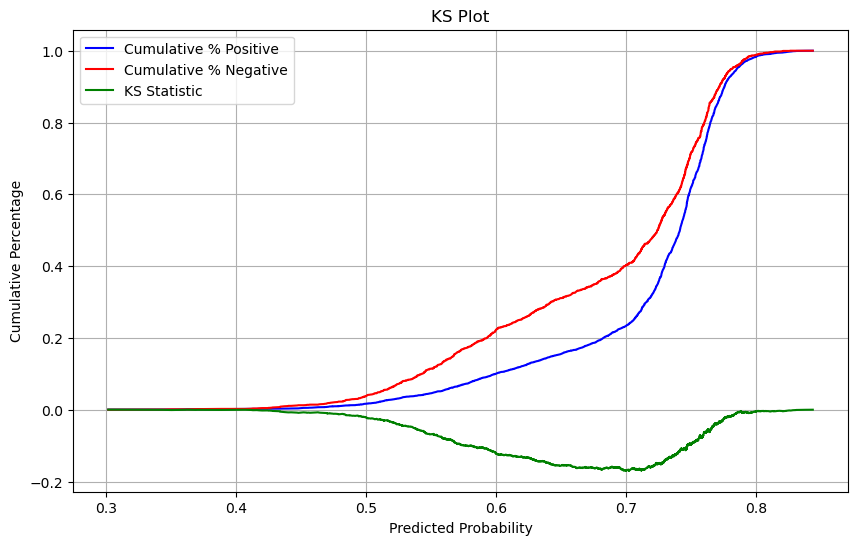

In [208]:
plt.figure(figsize=(10, 6))

plt.plot(results['prob'], results['cum_pos'], label='Cumulative % Positive', color='blue')
plt.plot(results['prob'], results['cum_neg'], label='Cumulative % Negative', color='red')

plt.plot(results['prob'], results['ks'], label='KS Statistic', color='green')

plt.title('KS Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True)
plt.show()


In [209]:
y_prob = best_model.predict_proba(X_test)[:, 1]  
y_true = y_test

results = pd.DataFrame({'prob': y_prob, 'true': y_true})

results['decile'] = pd.qcut(results['prob'], 10, labels=False) + 1  # Deciles from 1 to 10

decile_summary = results.groupby('decile').agg(
    avg_prob=('prob', 'mean'),
    avg_true=('true', 'mean')
).reset_index()

print(decile_summary)

   decile  avg_prob  avg_true
0       1  0.524367  0.503279
1       2  0.612499  0.594417
2       3  0.682645  0.692939
3       4  0.716523  0.735632
4       5  0.731015  0.763547
5       6  0.742883  0.752013
6       7  0.751033  0.762144
7       8  0.760243  0.754870
8       9  0.769147  0.770764
9      10  0.788346  0.767213


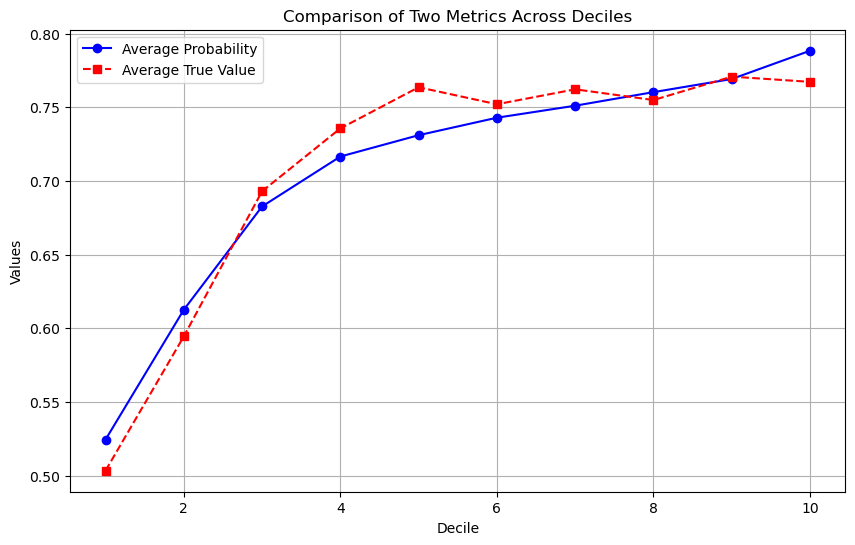

In [212]:
plt.figure(figsize=(10, 6))

plt.plot(decile_summary['decile'], decile_summary['avg_prob'], marker='o', linestyle='-', color='b', label='Average Probability')

plt.plot(decile_summary['decile'], decile_summary['avg_true'], marker='s', linestyle='--', color='r', label='Average True Value')

plt.title('Comparison of Two Metrics Across Deciles')
plt.xlabel('Decile')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

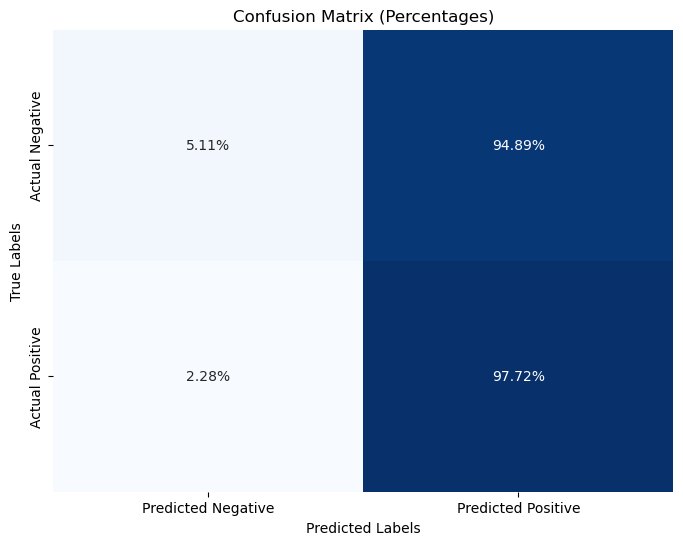

In [272]:
cm = confusion_matrix(y_test, y_pred)

# Step 2: Normalize the confusion matrix to percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 3: Display the normalized confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentages)')
plt.show()

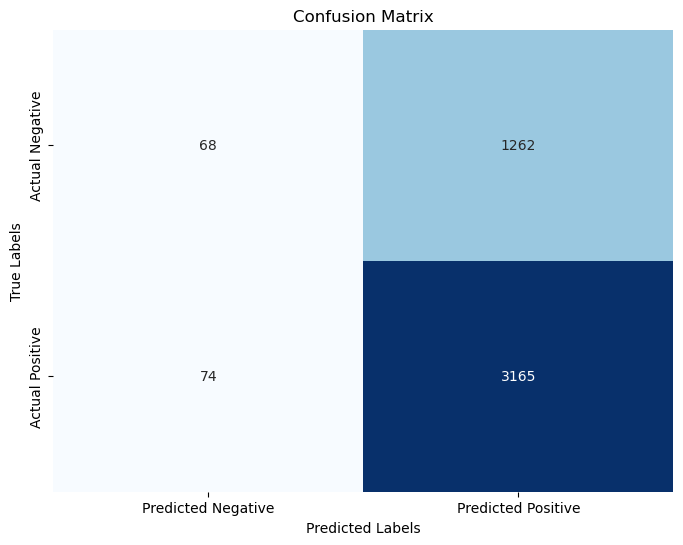

In [275]:
cm = confusion_matrix(y_test, y_pred)

# Step 2: Display the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

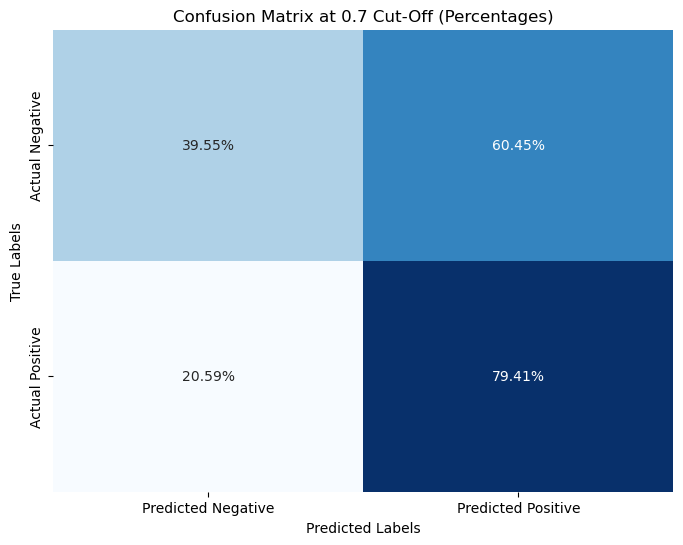

In [276]:
y_prob = model.predict_proba(X_test)[:, 1]

# Step 2: Apply the cut-off point of 0.7 to make binary predictions
cutoff = 0.7
y_pred_cutoff = (y_prob >= cutoff).astype(int)

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_cutoff)

# Step 4: Normalize the confusion matrix to show percentages (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 5: Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix at 0.7 Cut-Off (Percentages)')
plt.show()

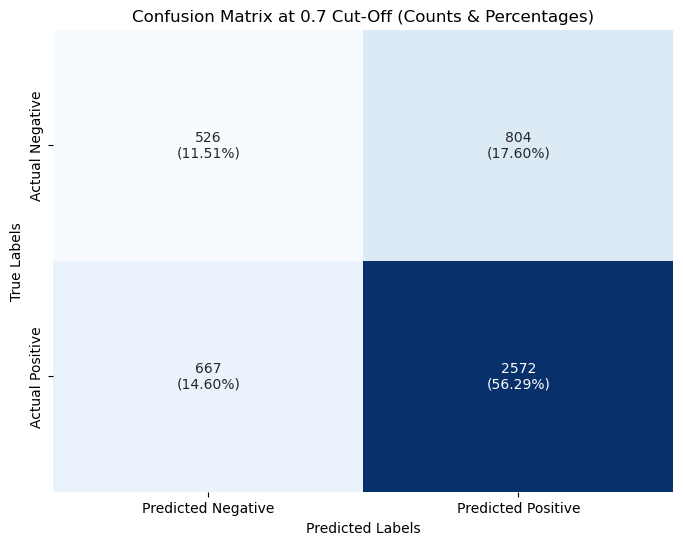

In [277]:
y_prob = model.predict_proba(X_test)[:, 1]

# Step 2: Apply the cut-off point of 0.7 to make binary predictions
cutoff = 0.7
y_pred_cutoff = (y_prob >= cutoff).astype(int)

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_cutoff)

# Step 4: Calculate percentages
cm_percentage = cm.astype('float') / cm.sum() * 100

# Step 5: Combine raw counts and percentages into a single annotation
labels = [f'{v1}\n({v2:.2f}%)' for v1, v2 in zip(cm.flatten(), cm_percentage.flatten())]
labels = np.asarray(labels).reshape(2, 2)

# Step 6: Display the confusion matrix with counts and percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix at 0.7 Cut-Off (Counts & Percentages)')
plt.show()

In [273]:
y_test.shape

(4569,)

In [274]:
y_pred.shape

(4569,)

### XG Boost

In [219]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [222]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy of the XGBoost model: {accuracy:.2f}')
print(f'ROC AUC score of the XGBoost model: {roc_auc:.2f}')

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:10:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of the XGBoost model: 0.70
ROC AUC score of the XGBoost model: 0.55


In [231]:
y_test_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy of the XGBoost model: {test_accuracy:.2f}')

Test Accuracy of the XGBoost model: 0.70


### Random Forest

In [223]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy of the RandomForest model: {accuracy:.2f}')
print(f'ROC AUC score of the RandomForest model: {roc_auc:.2f}')

/var/folders/c7/mwgyyxds33bg8rksxm07_r_00000gn/T/ipykernel_2298/3305685001.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy of the RandomForest model: 0.69
ROC AUC score of the RandomForest model: 0.52


### Neural Networks

In [224]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [227]:
model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy of the Neural Network model: {accuracy:.2f}')
print(f'ROC AUC score of the Neural Network model: {roc_auc:.2f}')

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1096: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the Neural Network model: 0.70
ROC AUC score of the Neural Network model: 0.56


In [215]:
y_pred = model.predict(X_test)

In [ ]:
visits_counts_insurance = new_visits['PRIMARY_INSURANCE_GRP'].value_counts()
category_percentages_insurance = new_visits['PRIMARY_INSURANCE_GRP'].value_counts(normalize=True) * 100

visits_summary_insurance = pd.DataFrame({'Count': visits_counts_insurance, 'Percentage': category_percentages_insurance})

print(visits_summary_insurance)

In [18]:
new_family_hx['Hypertension_Cholesterol'] = new_family_hx['CONDITION'].isin(hypertension_cholesterol).astype(int)
new_family_hx['Diabetes'] = new_family_hx['CONDITION'].isin(diabetes_conditions).astype(int)
new_family_hx['Cardiovascular_Diseases'] = new_family_hx['CONDITION'].isin(cardiovascular_diseases).astype(int)

family_hx_grouped = new_family_hx.groupby('PERSON_ID').agg({
    'Hypertension_Cholesterol': 'max',
    'Diabetes': 'max',
    'Cardiovascular_Diseases': 'max'
}).reset_index()

merged_person_familyhx = new_person.merge(family_hx_grouped, on='PERSON_ID', how='inner')

preeclampsia_events = ['Hypertension', 'High blood pressure', 'Pre-eclampsia']
diagnosis_preeclampsia = new_diagnosis[new_diagnosis['EVENT_DESC'].str.contains('|'.join(preeclampsia_events), case=False, na=False)]

top_10_reasons = new_visits['REASON_FOR_VISIT'].value_counts().head(10).index
new_visits = new_visits[new_visits['REASON_FOR_VISIT'].isin(top_10_reasons)]

merged_person_familyhx = merged_person_familyhx.merge(new_visits[['PERSON_ID', 'REASON_FOR_VISIT']], on='PERSON_ID', how='left')

merged_person_familyhx['Preeclampsia'] = merged_person_familyhx['PERSON_ID'].isin(diagnosis_preeclampsia['PERSON_ID']).astype(int)

X = merged_person_familyhx[['RACE', 'AGE_GROUP', 'Hypertension_Cholesterol', 'Diabetes', 'Cardiovascular_Diseases', 'REASON_FOR_VISIT']]  # Features
y = merged_person_familyhx['Preeclampsia']  

X_encoded = pd.get_dummies(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

base_learners = [
    ('lr', LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=100)),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

meta_classifier = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=100)

stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier, cv=5)

pipeline = Pipeline([
    ('rfe', RFE(estimator=LogisticRegression(), n_features_to_select=10, step=1)),
    ('stacking', stacking_clf)
])

param_grid = {
    'stacking__rf__n_estimators': [50, 100],
    'stacking__rf__max_depth': [3, 5, 7],
    'stacking__gb__n_estimators': [50, 100],
    'stacking__gb__learning_rate': [0.01, 0.1],
    'stacking__xgb__n_estimators': [50, 100],
    'stacking__xgb__learning_rate': [0.01, 0.1],
    'stacking__final_estimator__C': [0.1, 1, 10]  # Corrected to refer to the final_estimator
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')
print(classification_report(y_test, y_pred_best))

print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)



/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:21:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:26:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:27:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:31:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:34:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:34:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:34:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:34:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:34:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:36:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:37:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:37:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:37:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:37:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:37:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:37:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:37:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:38:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:40:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:43:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:43:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:43:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:45:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) o

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:47:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  wa

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:48:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yarayaghi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

Best Model Accuracy: 0.5302540415704388
              precision    recall  f1-score   support

           0       0.55      0.29      0.38      3229
           1       0.52      0.77      0.62      3266

    accuracy                           0.53      6495
   macro avg       0.54      0.53      0.50      6495
weighted avg       0.54      0.53      0.50      6495

Best hyperparameters found by GridSearchCV:
{'stacking__final_estimator__C': 0.1, 'stacking__gb__learning_rate': 0.01, 'stacking__gb__n_estimators': 100, 'stacking__rf__max_depth': 7, 'stacking__rf__n_estimators': 100, 'stacking__xgb__learning_rate': 0.1, 'stacking__xgb__n_estimators': 100}
